### Relevant Links
- https://openai.com/blog/introducing-text-and-code-embeddings/
- https://platform.openai.com/docs/guides/embeddings/what-are-embeddings
- https://github.com/openai/openai-cookbook/blob/main/examples/Question_answering_using_embeddings.ipynb
- https://platform.openai.com/docs/api-reference/completions/create

In [1]:
import openai
import json
from importlib import reload

with open("openai_api.json") as f:
    creds = json.load(f)

openai.api_version = creds["api_version"]
openai.api_base = creds["api_base"]
openai.api_type = creds["api_type"]
openai.api_key = creds["api_key"]

In [89]:
# List of models:
# [(m.id, m.status) for m in openai.Model.list()["data"]]

### Completion API

In [2]:
def get_prompt(p_context, p_question):
    p_prompt = f"""Answer the question as truthfully as possible using the provided text, and if the answer is not contained within the text below, say "I don't know".

Context:
{p_context}
Question: {p_question}
Answer:
"""
    return p_prompt

def complete(p_prompt):
    response = openai.Completion.create(
        prompt=p_prompt,
        deployment_id="text-chat-davinci-002",  # token limit: ~4000
        temperature=0.0,
        max_tokens=150,
        stop="\n\n",
    )
    # (no. of tokens in prompt + max_tokens arg) should be < token limit
    # return response
    return response["choices"][0]["text"]

In [3]:
# context taken from: https://www.microsoft.com/en-us/research/project/project-florence-vl/
context = """One of the core aspirations in artificial intelligence is to develop
algorithms that endow computers with an ability to effectively learn from
multi-modality (or multi-channel) data. This data is similar to sights and
sounds attained from vision and language that help humans make sense of the
world around us. For example, computers could mimic this ability by searching
the most similar images for a text query (or vice versa) and by describing the
content of an image using natural language.
Azure Florence-Vision and Language, short for Florence-VL, is launched to
achieve this goal, where we aim to build new foundation models for Multimodal
Intelligence. Florence-VL, as part of Project
Florence, is funded by the Microsoft AI
Cognitive Service team since 2020. Motivated by the strong demand from real
applications and recent research progresses on computer vision, natural
language processing, and vision-language understanding, we strive to advance
the state of the art on vision-language modeling and develop the best computer
vision technologies as part of our mission to empower everyone on the planet
to achieve more.
"""
question = "What is florence-vl about"
# question = "What does florence-vl stand for"

prompt = get_prompt(context, question)
print(complete(prompt))

Florence-VL, as part of Project Florence, is about building new foundation models for Multimodal Intelligence. The goal is to endow computers with an ability to effectively learn from multi-modality (or multi-channel) data, similar to sights and sounds attained from vision and language that help humans make sense of the world around us. The project is funded by the Microsoft AI Cognitive Service team since 2020 and aims to advance the state of the art on vision-language modeling and develop the best computer vision technologies as part of the mission to empower everyone on the planet to achieve more. 


### Embeddings

In [5]:
import pandas as pd
import numpy as np
from openai.embeddings_utils import cosine_similarity

In [6]:
def get_embedding(text, model):
    response = openai.Embedding.create(input=text, deployment_id=model)
    return response["data"][0]["embedding"]

#### Text Similarity

In [71]:
sentences = [
    # dog
    "my dog acts weird sometimes",
    "canine's have pointy teeth",
    "man's best friend",
    
    # cat
    "the cat jumped over the wall",
    "meow",
    
    # football
    "a quaterback throws a football"
]
similarity_df = pd.DataFrame()
similarity_df["sentence"] = sentences
similarity_df["embedding"] = similarity_df["sentence"].apply(lambda x: get_embedding(x, "text-similarity-davinci-001"))
similarity_df.head(2)

,sentence,embedding
0,my dog acts weird sometimes,"[-0.012331393547356129, -0.005718032829463482,..."
1,canine's have pointy teeth,"[-0.00214831018820405, 0.00017978779214899987,..."


In [72]:
from operator import itemgetter
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

matrix = np.vstack(similarity_df["embedding"].values)

# finding best K using Silhouette method: https://medium.com/analytics-vidhya/how-to-determine-the-optimal-k-for-k-means-708505d204eb
scores = []
for n_clusters in range(2, len(similarity_df)):
    kmeans = KMeans(n_clusters=n_clusters, init='k-means++', n_init=10, random_state=42)
    kmeans.fit(matrix)
    labels = kmeans.labels_
    score = silhouette_score(matrix, labels, metric='cosine')
    print(f"n_clusters={n_clusters} score={score} labels={labels}")
    scores.append((n_clusters, score, labels))

best_n_clusters, best_score, best_labels = max(scores, key=itemgetter(1))
print("Best:", f"n_clusters={best_n_clusters} score={best_score} labels={best_labels}")
# FIXME: best n_clusters should be 3, not 4

best_n_clusters = 3
best_labels = [s[2] for s in scores if s[0] == best_n_clusters][0]
similarity_df["Cluster"] = best_labels
similarity_df

n_clusters=2 score=0.17306461993193134 labels=[0 0 0 1 0 1]
n_clusters=3 score=0.16376671789563968 labels=[1 1 1 0 0 2]
n_clusters=4 score=0.10033701320864674 labels=[1 1 1 0 3 2]
n_clusters=5 score=0.03341732028023456 labels=[2 1 1 0 4 3]
Best: n_clusters=2 score=0.17306461993193134 labels=[0 0 0 1 0 1]


,sentence,embedding,Cluster
0,my dog acts weird sometimes,"[-0.012331393547356129, -0.005718032829463482,...",1
1,canine's have pointy teeth,"[-0.00214831018820405, 0.00017978779214899987,...",1
2,man's best friend,"[-0.011485903523862362, 0.003112883074209094, ...",1
3,the cat jumped over the wall,"[-0.0073088095523417, 0.0033210315741598606, -...",0
4,meow,"[0.0011831376468762755, 0.003737061284482479, ...",0
5,a quaterback throws a football,"[-0.019677966833114624, 0.00196112715639174, -...",2


Text(0.5, 1.0, 'Clusters identified visualized in language 2d using t-SNE')

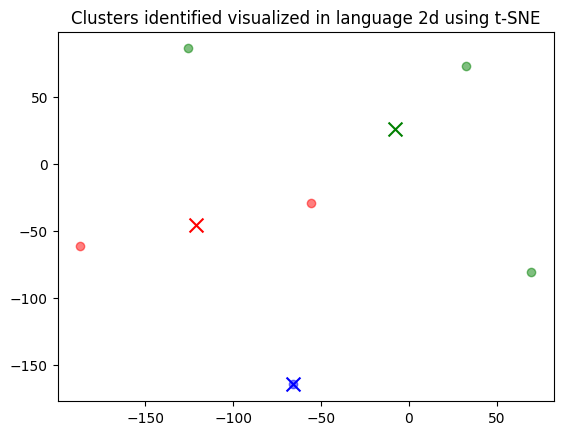

In [74]:
from sklearn.manifold import TSNE
import matplotlib
import matplotlib.pyplot as plt

perplexity = min(5, len(similarity_df))
tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42, init="random", learning_rate=200)
vis_dims2 = tsne.fit_transform(matrix)

x = [x for x, y in vis_dims2]
y = [y for x, y in vis_dims2]

for category, color in enumerate(["red", "green", "blue"]):
    xs = np.array(x)[similarity_df.Cluster == category]
    ys = np.array(y)[similarity_df.Cluster == category]
    plt.scatter(xs, ys, color=color, alpha=0.5)

    avg_x = xs.mean()
    avg_y = ys.mean()

    plt.scatter(avg_x, avg_y, marker="x", color=color, s=100)
plt.title("Clusters identified visualized in language 2d using t-SNE")

#### Text Search

In [200]:
import tiktoken

encoding = tiktoken.get_encoding("gpt2")

def get_tokens(text):
    return encoding.encode(text)

tokens = get_tokens("What is florence-vl about")
for token in tokens:
    print(f"{token}:", encoding.decode([token]))

2061: What
318:  is
781:  fl
382: ore
1198: nce
12: -
19279: vl
546:  about


In [221]:
import re
import requests
from bs4 import BeautifulSoup

r = requests.get("https://www.microsoft.com/en-us/research/project/project-florence-vl/")
soup = BeautifulSoup(r.text, features='html.parser')
text = soup.get_text()
text = re.sub(r"[\n\t]+", "\n", text)
lines = [line for line in text.split("\n") if len(line) > 30]  # small lines don't have much information
text = "\n".join(lines)

filepath = "data/project-florence-vl.txt"
with open(filepath, "w") as f:
    f.write(text)

In [232]:
def get_chunks(text):
    SIZE = 4000
    chunks = []
    for i in range(0, len(text), SIZE):  # naive chunking
        chunk = text[i:i+SIZE]
        chunks.append(chunk)
    return chunks

with open(filepath) as f:
    text = f.read()
chunks = get_chunks(text)

In [233]:
df = pd.DataFrame.from_dict({
    "file": [filepath] * len(chunks),
    "chunk_text": chunks,
})
df["chunk_token_count"] = df["chunk_text"].apply(lambda x: len(get_tokens(x)))
df

,file,chunk_text,chunk_token_count
0,data/project-florence-vl.txt,Project Florence-VL - Microsoft Research\n ...,847
1,data/project-florence-vl.txt,on model trained on 800M image-text pairs. GIT...,879
2,data/project-florence-vl.txt,he common interface for all pre-training and d...,825
3,data/project-florence-vl.txt,that the more and more accurate pseudo labels ...,288


In [234]:
df["embedding"] = df["chunk_text"].apply(lambda x: get_embedding(x, "text-search-davinci-doc-001"))  # token limit: ~2000
df

,file,chunk_text,chunk_token_count,embedding
0,data/project-florence-vl.txt,Project Florence-VL - Microsoft Research\n ...,847,"[0.0013549693394452333, 0.008274282328784466, ..."
1,data/project-florence-vl.txt,on model trained on 800M image-text pairs. GIT...,879,"[-0.002092509064823389, 0.0050740959122776985,..."
2,data/project-florence-vl.txt,he common interface for all pre-training and d...,825,"[-0.010482553392648697, 0.006804130505770445, ..."
3,data/project-florence-vl.txt,that the more and more accurate pseudo labels ...,288,"[-0.004963461309671402, 0.007704003248363733, ..."


In [261]:
def get_qa_df(p_df, p_question):
    question_embedding = get_embedding(p_question, "text-search-davinci-query-001")  # token limit: ~2000
    qa_df = p_df.copy()
    qa_df["similarity"] = df["embedding"].apply(lambda x: cosine_similarity(x, question_embedding))
    return qa_df

# question = "what are multi channel videos"
# question = "what is the full form of GLIP and what is it about"
question = "what is the difference between project florence and project florence-vl"
qa_df = get_qa_df(df, question)
qa_df

,file,chunk_text,chunk_token_count,embedding,similarity
0,data/project-florence-vl.txt,Project Florence-VL - Microsoft Research\n ...,847,"[0.0013549693394452333, 0.008274282328784466, ...",0.364001
1,data/project-florence-vl.txt,on model trained on 800M image-text pairs. GIT...,879,"[-0.002092509064823389, 0.0050740959122776985,...",0.233602
2,data/project-florence-vl.txt,he common interface for all pre-training and d...,825,"[-0.010482553392648697, 0.006804130505770445, ...",0.244051
3,data/project-florence-vl.txt,that the more and more accurate pseudo labels ...,288,"[-0.004963461309671402, 0.007704003248363733, ...",0.233082


In [263]:
def get_answer(context, question):
    prompt = get_prompt(context, question)
    return complete(prompt)

answers = list(qa_df["chunk_text"].apply(lambda x: get_answer(x, question)))
for i, answer in enumerate(answers):
    print(f"Answer{i}:", answer)

Answer0: Project Florence is the overarching project that includes Florence-VL as a subproject. Florence-VL is focused on building new foundation models for Multimodal Intelligence, while the goals of the larger Project Florence are not specified in the text.
Answer1: I don't know. 
Answer2: I don't know.
Answer3: I don't know.
